# Introduction - Visualisations on Small Instances

In [10]:
import sys
import os
import random
import copy
from typing import TypeVar, TextIO, Tuple, List, Dict

# If not installed, run the following command 
# and reload the kernel: sage --pip install segment-tree
import segment_tree as sg 

random.seed(int(5787549218))

PATH = "./data"

In [11]:
# Reference: pace2024-verifier package (https://pypi.org/project/pace2024-verifier/)
class PaceGraph():
    # Only the right side is flexible
    left: int
    right: list
    right_order: Dict[int, int]
    edgeset: List[Tuple[int, int]]
    edges: Dict[int, List[int]] # adjacency list

    # Build a graph with sides A and B of size a and b. The side B is assumed to be flexible and A to be fixed.
    # If order is given we set the right side to be ordered that way. 
    def __init__(self, a: int, b: int, edges: list, order: list = None):
        if order:
            oelements = set(order)
            relements = set(range(a + 1, a + b + 1))
            diff = oelements - relements
            if len(diff) != 0 :
                raise ValueError(f"Error! 'order' contains elements not present in the graph {diff}.")
            else:
                self.right = order
        else:
            self.right = list(range(a + 1, a + b + 1))
        
        self.right_order = {u: p for p, u in enumerate(self.right)}
        self.left = a
        self.edges = {}
        self.edgeset = []
        edges = sorted(edges) # sort all edges such that we get sorted adjacency lists
        for e in edges:
            u = e[0] if e[0] < e[1] else e[1]
            v = e[0] if e[1] < e[0] else e[1]
            if not (u in self.edges.keys()):
                self.edges[u] = []
            if not (v in self.edges.keys()):
                self.edges[v] = []
            self.edges[u].append(v)
            self.edges[v].append(u)
            self.edgeset.append((u,v))
        for v in range(1,a+b+1):
            if v not in self.edges.keys():
                self.edges[v] = []
    
    # Set the order to the given list
    def set_order(self, order: List[int], check: bool = False):
        if check:
            oelements = set(order)
            relements = set(range(len(self.right) + 1, len(self.right) + self.left + 1))
            diff = oelements - relements
            if len(diff) != 0 :
                raise ValueError(f"Error! 'order' contains elements not present in the graph {diff}.")
            else:
                self.right = order
        self.right = order
        self.right_order = {u: p for p, u in enumerate(self.right)}

    # Check if edges (a,b) and (c,d) cross
    def cross(self, a: int, b: int, c: int, d: int) -> bool:
        if a > b:
            a, b = b, a
        if c > d:
            c, d = d, c
        b = self.right_order[b]
        d = self.right_order[d]
        return (a < c and b > d) or (c < a and d > b)
    
    # Swap the position of two vertices in the order
    def swap(self, a: int, b: int):
        apos = self.right_order[a]
        bpos = self.right_order[b]
        self.right[apos], self.right[bpos] = self.right[bpos], self.right[apos]
        self.right_order[a] = bpos
        self.right_order[b] = apos

    # Count the crossings in the trivial way by iterating all edges and checking if they cross.
    def countcrossings_trivial(self) -> int:
        crossings = 0
        for a in range(1, self.left+1):
            for c in range(a + 1, self.left+1):
                for b in self.edges[a]:
                    for d in self.edges[c]:
                        if self.cross(a, b, c, d):
                            crossings += 1
        return int(crossings)

    
    def countcrossings_segtree(self) -> int:
        size = len(self.right)
        edges = sorted(self.edgeset, key=lambda e: (e[0], self.right_order[e[1]]))
        arr = [0] * (size + 1)
        t = sg.SegmentTree(arr)
        crossings = 0
        for edge in edges:
            old = t.query(self.right_order[edge[1]], self.right_order[edge[1]], "sum")
            t.update(self.right_order[edge[1]], old+1)
            if size > self.right_order[edge[1]]+1:
                crossings_found = t.query(self.right_order[edge[1]]+1, size, "sum")
                crossings += crossings_found
        return crossings


    def show(self, title=""):
        e = [(x, y) for (v, w) in self.edgeset 
                 if (x := self.right_order[v]+self.left+1 if v > self.left else v) and 
                    (y := self.right_order[w]+self.left+1 if w > self.left else w)
            ]
        g = BipartiteGraph(e)
        g.left = [i for i in range(1,self.left+1)]
        g.right = self.right
        return g.plot(title=title, vertex_labels=all(i < j for i, j in zip(self.right, self.right[1:])))

    
    def randomly_permute(self):
        new_order = self.right
        random.shuffle(new_order)
        self.set_order(new_order)


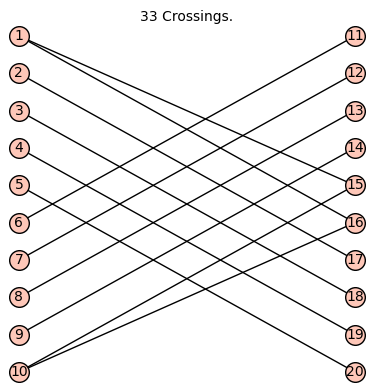

In [3]:
N0 = -1; N1 = -1
E = list()

with open(os.path.join(PATH, "tiny/website_20.gr"), 'r') as f:
    for l in f.readlines():
        l = l.split()
        if l[0][0] == 'p':
            N0 = Integer(l[2])
            N1 = Integer(l[3])
        elif l[0][0] != 'c':
            edge = (Integer(l[0]), Integer(l[1]))
            E.append(edge)

G = PaceGraph(N0, N1, E)
G.show(title=f"{G.countcrossings_trivial()} Crossings.")

## Randomize Permutation of B

Run the following cell several times:

30


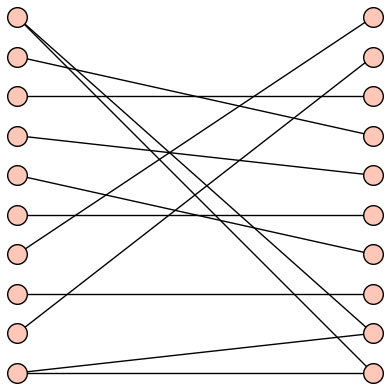

In [18]:

G.randomly_permute()

print(G.countcrossings_trivial())
G.show()#title=f"{G.countcrossings_trivial()} Crossings.")


## Naive Guessing

Perhaps the simplest way to obtain a better result is to run a large number of trials and take the best result.

Ordering of (right-side) vertices from top to bottom: [20, 12, 17, 19, 16, 13, 18, 11, 15, 14].
17


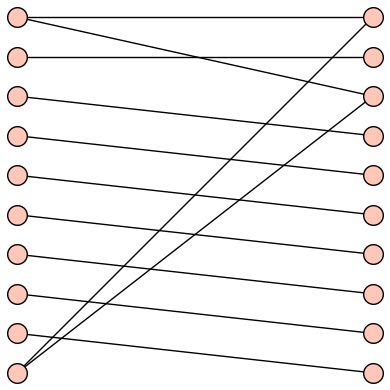

In [25]:
min_crossings = float('inf')
min_G = None

for _ in range(100000):
    G.randomly_permute()
    c = G.countcrossings_trivial()
    if c < min_crossings:
        min_crossings = c
        min_G = copy.copy(G)

print(f"Ordering of (right-side) vertices from top to bottom: {min_G.right}.")
print(min_G.countcrossings_trivial())
min_G.show()#title=f"{min_G.countcrossings_trivial()} Crossings.")

## Evaluation on Tiny Set

We compare this method on small graphs with their true solutions.

In [7]:
tests = sorted([f for f in os.listdir(os.path.join(PATH, "tiny")) if os.path.isfile(os.path.join(os.path.join(PATH, "tiny"), f))])
results = {k:dict() for k in tests}

for test in tests:
    # Read and create graph
    N0 = -1; N1 = -1
    E = list()
    with open(os.path.join(PATH, f"tiny/{test}"), 'r') as f:
        for l in f.readlines():
            l = l.split()
            if l[0][0] == 'p':
                N0 = Integer(l[2])
                N1 = Integer(l[3])
            elif l[0][0] != 'c':
                edge = (Integer(l[0]), Integer(l[1]))
                E.append(edge)
    G = PaceGraph(N0, N1, E)

    # Randomized trials
    min_crossings = float('inf')
    for _ in range(10000):
        G.randomly_permute()
        min_crossings = min(min_crossings, G.countcrossings_trivial())
    results[test]["result"] = min_crossings

    # Evaluation
    true_order = []
    with open(os.path.join(PATH, f"tiny-sol/{test[:-3]}.sol")) as f:
        for l in f.readlines():
            true_order.append(Integer(l))
    G.set_order(true_order)
    results[test]["solution"] = G.countcrossings_trivial()

for k, v in results.items():
    print(f"{k} \t Result: {v['result']} \t Solution: {v['solution']}")

complete_4_5.gr 	 Result: 60 	 Solution: 60
cycle_8_shuffled.gr 	 Result: 4 	 Solution: 4
cycle_8_sorted.gr 	 Result: 3 	 Solution: 3
grid_9_shuffled.gr 	 Result: 17 	 Solution: 17
ladder_4_4_shuffled.gr 	 Result: 11 	 Solution: 11
ladder_4_4_sorted.gr 	 Result: 3 	 Solution: 3
matching_4_4.gr 	 Result: 0 	 Solution: 0
path_9_shuffled.gr 	 Result: 6 	 Solution: 6
path_9_sorted.gr 	 Result: 0 	 Solution: 0
plane_5_6.gr 	 Result: 0 	 Solution: 0
star_6.gr 	 Result: 0 	 Solution: 0
tree_6_10.gr 	 Result: 15 	 Solution: 13
website_20.gr 	 Result: 18 	 Solution: 17
